In [20]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\navne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\navne\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\navne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [21]:
train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Preprocess the text data
def preprocess(text):
    text = text.lower() 
    #Removing IP address
    text=re.sub(r"([0-9]{1,3})\.([0-9]{1,3})\.([0-9]{1,3})\.([0-9]{1,3})","",text)

    #Getting ride of the URLs with space even if they are in paranthesis 

    text=re.sub(r"\S*https?:\S*|\s*www\.\s*", "", text)

    text=re.sub(r"\"\"", "\"",text)  # replacing "" with "

    text=re.sub(r"^\"", "",text)      # removing quotation from start and the end of the string

    #Remove special characters and numbers 
    text=re.sub(r'\s*[^a-zA-Z]\s*',' ',text)

    #Removing extra spaces in the text 
    text=re.sub(r"\s\s+", " ",text)

    # Remove stopwords
    words = word_tokenize(text)
    words = [w for w in words if not w in stop_words]
    return text


In [24]:
#cleaning data using function defined above
train_df['preprocessedtext'] = train_df['comment_text'].apply(lambda x: preprocess(x))
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessedtext
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww he matches this background colour i m se...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i m really not trying to edit war it s...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can t make any real suggestions on imp...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [25]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                tok = re.sub('\W+','', tok) #Punctuation strip
                tmp = self.lemmatizer.lemmatize(tok)
                if len(tmp) >= 2:
                    filtered_tok.append(tmp)
        return filtered_tok

In [26]:
class stemTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import SnowballStemmer
        self.stemmer = SnowballStemmer(language='english')
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.stemmer.stem(tok))
        return filtered_tok

In [27]:
class swTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(tok)
        return filtered_tok

In [28]:
#defining target and input variables
y_toxic=np.array(train_df['toxic']).reshape(-1,1)
y_sevtoxic=np.array(train_df['severe_toxic']).reshape(-1,1)
y_obscene=np.array(train_df['obscene']).reshape(-1,1)
y_threat=np.array(train_df['threat']).reshape(-1,1)
y_insult=np.array(train_df['insult']).reshape(-1,1)
y_identityhate=np.array(train_df['identity_hate']).reshape(-1,1)
X=train_df['preprocessedtext']

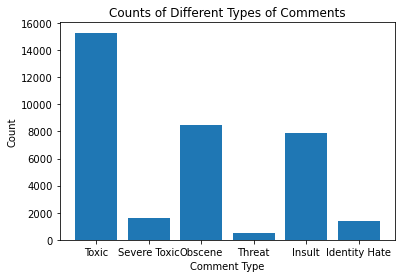

In [29]:
import matplotlib.pyplot as plt
#count plots for different types of comments
counts = [y_toxic.sum(), y_sevtoxic.sum(), y_obscene.sum(), y_threat.sum(), y_insult.sum(), y_identityhate.sum()]
labels = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']

plt.bar(labels, counts)
plt.title('Counts of Different Types of Comments')
plt.xlabel('Comment Type')
plt.ylabel('Count')
plt.show()



these classes are imbalanced.

In [30]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [31]:
#oversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority')

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.stemTokenizer object at 0x00000214C81B8610>)),
                ('model', MultinomialNB())])
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     36078
           1       0.94      0.49      0.64      3815

    accuracy                           0.95     39893
   macro avg       0.94      0.74      0.81     39893
weighted avg       0.95      0.95      0.94     39893



<AxesSubplot:>

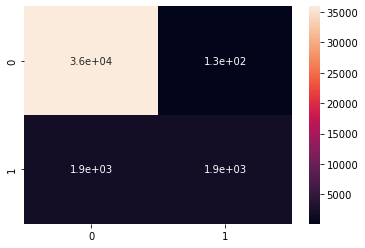

In [32]:
#toxic 
from sklearn.svm import SVC
X_tx=train_df['preprocessedtext']
vec = TfidfVectorizer()
model_nb = MultinomialNB()
#model_svc=SVC()
#ros = RandomOverSampler(sampling_strategy='minority')
#ros_pipeline = Pipeline([ ("ros", ros),])

X_train_tx, X_test_tx, y_train_tx, y_test_tx = train_test_split(X_tx, y_toxic,random_state=42)
pipe1 = Pipeline([
                    ("vect", vec),
                    #("ros_pipeline",ros_pipeline),
                    ("model", model_nb)
])

params1 = {"vect__max_features":[1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            #"vect__norm":["l1","l2"]
            }

grid1 = GridSearchCV(estimator  = pipe1, 
                               param_grid = params1, 
                               scoring    = "balanced_accuracy",
                               cv         = 3,
                               n_jobs     =-1)

grid1.fit(X_train_tx, y_train_tx)
best1 = grid1.best_estimator_
pred1 = best1.predict(X_test_tx)
print(best1)
print(classification_report(y_test_tx, pred1))
sns.heatmap(confusion_matrix(y_test_tx, pred1), annot=True)


In [33]:
best1.fit(X,y_toxic)

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.stemTokenizer object at 0x00000214C81B8610>)),
                ('model', MultinomialNB())])

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.lemmaTokenizer object at 0x00000214C81A7760>)),
                ('model', MultinomialNB())])
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39487
           1       0.57      0.31      0.40       406

    accuracy                           0.99     39893
   macro avg       0.78      0.65      0.70     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

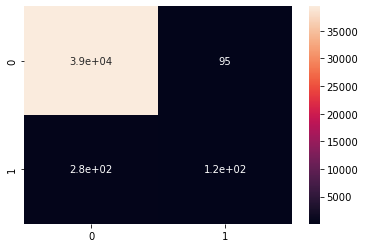

In [34]:
#severe toxic
vec = TfidfVectorizer()
model_nb = MultinomialNB()
#model_svc=SVC()
#ros = RandomOverSampler(sampling_strategy='minority')
#ros_pipeline = Pipeline([ ("ros", ros),])
X_st=train_df['preprocessedtext']
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X_st, y_sevtoxic,random_state=42)
pipe2= Pipeline([ 
                    ("vect", vec),
                    #("ros_pipeline",ros_pipeline),
                    ("model", model_nb)
])

params2 = {"vect__max_features":[1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            #"vect__norm":["l1","l2"]
            }

grid2 = GridSearchCV(estimator  = pipe2, 
                               param_grid = params2, 
                               scoring    = "balanced_accuracy",
                               cv         = 3,
                               n_jobs     =-1)

grid2.fit(X_train_st, y_train_st)
best2 = grid2.best_estimator_
pred2 = best2.predict(X_test_st)
print(best2)
print(classification_report(y_test_st, pred2))
sns.heatmap(confusion_matrix(y_test_st, pred2), annot=True)

In [35]:
best2.fit(X,y_sevtoxic)

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.lemmaTokenizer object at 0x00000214C81A7760>)),
                ('model', MultinomialNB())])

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.lemmaTokenizer object at 0x00000214E1383040>)),
                ('model', MultinomialNB())])
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     37750
           1       0.92      0.53      0.68      2143

    accuracy                           0.97     39893
   macro avg       0.95      0.77      0.83     39893
weighted avg       0.97      0.97      0.97     39893



<AxesSubplot:>

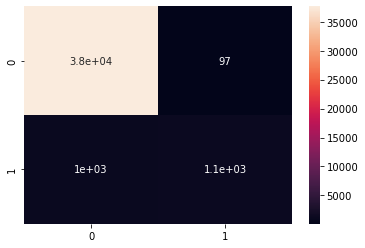

In [36]:
#obscene
vec = TfidfVectorizer()
model_nb = MultinomialNB()
#model_svc=SVC()
#ros = RandomOverSampler(sampling_strategy='minority')
#ros_pipeline = Pipeline([ ("ros", ros),])
X_obs=train_df['preprocessedtext']
X_train_obs, X_test_obs, y_train_obs, y_test_obs = train_test_split(X_obs, y_obscene,random_state=42)
pipe3 = Pipeline([ 
                    ("vect", vec),
                    #("ros_pipeline",ros_pipeline),
                    ("model", model_nb)
])

params3 = {"vect__max_features":[1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            #"vect__norm":["l1","l2"]
            }

grid3 = GridSearchCV(estimator  = pipe3, 
                               param_grid = params3, 
                               scoring    = "balanced_accuracy",
                               cv         = 3,
                               n_jobs     =-1)

grid3.fit(X_train_obs, y_train_obs)
best3 = grid3.best_estimator_
pred3 = best3.predict(X_test_obs)
print(best3)
print(classification_report(y_test_obs, pred3))
sns.heatmap(confusion_matrix(y_test_obs, pred3), annot=True)

In [37]:
best3.fit(X,y_obscene)

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.lemmaTokenizer object at 0x00000214E1383040>)),
                ('model', MultinomialNB())])

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.swTokenizer object at 0x00000214ED2B96D0>)),
                ('model', MultinomialNB())])
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39788
           1       0.67      0.02      0.04       105

    accuracy                           1.00     39893
   macro avg       0.83      0.51      0.52     39893
weighted avg       1.00      1.00      1.00     39893



<AxesSubplot:>

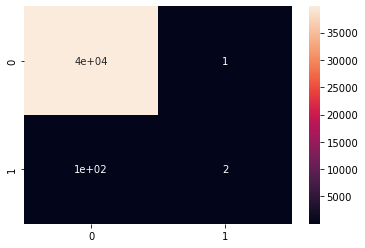

In [38]:
#Threat
vec = TfidfVectorizer()
model_nb = MultinomialNB()
#model_svc=SVC()
#ros = RandomOverSampler(sampling_strategy='minority')
#ros_pipeline = Pipeline([ ("ros", ros),])
X_th=train_df['preprocessedtext']
X_train_th, X_test_th, y_train_th, y_test_th = train_test_split(X_th, y_threat,random_state=42)
pipe4 = Pipeline([ 
                    ("vect", vec),
                    #("ros_pipeline",ros_pipeline),
                    ("model", model_nb)
])

params4 = {"vect__max_features":[1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            #"vect__norm":["l1","l2"]
            }

grid4 = GridSearchCV(estimator  = pipe4, 
                               param_grid = params4, 
                               scoring    = "balanced_accuracy",
                               cv         = 3,
                               n_jobs     =-1)

grid4.fit(X_train_th, y_train_th)
best4 = grid4.best_estimator_
pred4 = best4.predict(X_test_th)
print(best4)
print(classification_report(y_test_th, pred4))
sns.heatmap(confusion_matrix(y_test_th, pred4), annot=True)

In [39]:
best4.fit(X,y_threat)

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.swTokenizer object at 0x00000214ED2B96D0>)),
                ('model', MultinomialNB())])

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.lemmaTokenizer object at 0x00000214EE70A880>)),
                ('model', MultinomialNB())])
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     37882
           1       0.82      0.44      0.57      2011

    accuracy                           0.97     39893
   macro avg       0.90      0.72      0.78     39893
weighted avg       0.96      0.97      0.96     39893



<AxesSubplot:>

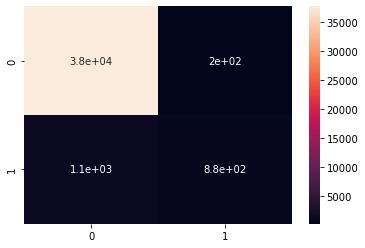

In [40]:
#insult
vec = TfidfVectorizer()
model_nb = MultinomialNB()
#model_svc=SVC()
#ros = RandomOverSampler(sampling_strategy='minority')
#ros_pipeline = Pipeline([ ("ros", ros),])
X_in=train_df['preprocessedtext']
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(X_in, y_insult,random_state=42)
pipe5 = Pipeline([ 
                    ("vect", vec),
                    #("ros_pipeline",ros_pipeline),
                    ("model", model_nb)
])

params5 = {"vect__max_features":[1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            #"vect__norm":["l1","l2"]
            }

grid5 = GridSearchCV(estimator  = pipe5, 
                               param_grid = params5, 
                               scoring    = "balanced_accuracy",
                               cv         = 3,
                               n_jobs     =-1)

grid5.fit(X_train_in, y_train_in)
best5 = grid5.best_estimator_
pred5 = best5.predict(X_test_in)
print(best5)
print(classification_report(y_test_in, pred5))
sns.heatmap(confusion_matrix(y_test_in, pred5), annot=True)

In [41]:
best5.fit(X,y_insult)

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.lemmaTokenizer object at 0x00000214EE70A880>)),
                ('model', MultinomialNB())])

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.stemTokenizer object at 0x00000214EED33970>)),
                ('model', MultinomialNB())])
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39536
           1       0.52      0.10      0.17       357

    accuracy                           0.99     39893
   macro avg       0.76      0.55      0.58     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

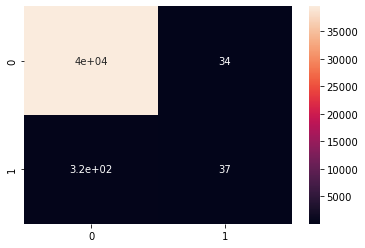

In [42]:
#identity hate
vec = TfidfVectorizer()
model_nb = MultinomialNB()
#model_svc=SVC()
#ros = RandomOverSampler(sampling_strategy='minority')
#ros_pipeline = Pipeline([ ("ros", ros),])
X_ht=train_df['preprocessedtext']
X_train_ht, X_test_ht, y_train_ht, y_test_ht = train_test_split(X_ht, y_identityhate,random_state=42)
pipe6 = Pipeline([ 
                    ("vect", vec),
                    #("ros_pipeline",ros_pipeline),
                    ("model", model_nb)
])

params6 = {"vect__max_features":[1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            #"vect__norm":["l1","l2"]
            }

grid6 = GridSearchCV(estimator  = pipe6, 
                               param_grid = params6, 
                               scoring    = "balanced_accuracy",
                               cv         = 3,
                               n_jobs     =-1)

grid6.fit(X_train_ht, y_train_ht)
best6= grid6.best_estimator_
pred6= best6.predict(X_test_ht)
print(best6)
print(classification_report(y_test_ht, pred6))
sns.heatmap(confusion_matrix(y_test_ht, pred6), annot=True)

In [43]:
best6.fit(X,y_identityhate)

c:\Users\navne\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500,
                                 tokenizer=<__main__.stemTokenizer object at 0x00000214EED33970>)),
                ('model', MultinomialNB())])

## Test Data

In [44]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


In [46]:
# Preprocess the comment_text column using the same pre-processing steps as for training data

test_df['preprocessedtext'] = test_df['comment_text'].apply(lambda x: preprocess(x))
test_df.head()

,id,comment_text,preprocessedtext
0,1,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule is more succesful then you ll...
1,2,== From RfC == \n\n The title is fine as it is...,from rfc the title is fine as it is imo
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton on lapland
3,4,":If you have a look back at the source, the in...",if you have a look back at the source the inf...
4,5,I don't anonymously edit articles at all.,i don t anonymously edit articles at all


In [53]:
test_df['preprocessedtext']

0         yo bitch ja rule is more succesful then you ll...
1                  from rfc the title is fine as it is imo 
2                           sources zawe ashton on lapland 
3          if you have a look back at the source the inf...
4                 i don t anonymously edit articles at all 
                                ...                        
153159     i totally agree this stuff is nothing but too...
153160     throw from out field to home plate does it ge...
153161     okinotorishima categories i see your changes ...
153162     one of the founding nations of the eu germany...
153163     stop already your bullshit is not welcome her...
Name: preprocessedtext, Length: 153164, dtype: object

In [ ]:
test_df.head()

In [61]:


# Use the trained model to predict the toxicity levels
#predictions = best1.predict(preprocessed_text)
t1=best1.predict(test_df['preprocessedtext'])
t2=best2.predict(test_df['preprocessedtext'])
t3=best3.predict(test_df['preprocessedtext'])
t4=best4.predict(test_df['preprocessedtext'])
t5=best5.predict(test_df['preprocessedtext'])
t6=best6.predict(test_df['preprocessedtext'])



In [69]:
test_df['toxic']=t1
test_df['severe_toxic']=t2
test_df['obscene']=t3
test_df['threat']=t4
test_df['insult']=t5
test_df['identity_hate']=t6
test_df.head()

,id,preprocessedtext,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,yo bitch ja rule is more succesful then you ll...,1,0,1,0,1,0
1,2,from rfc the title is fine as it is imo,0,0,0,0,0,0
2,3,sources zawe ashton on lapland,0,0,0,0,0,0
3,4,if you have a look back at the source the inf...,0,0,0,0,0,0
4,5,i don t anonymously edit articles at all,0,0,0,0,0,0


In [71]:
test_df.drop( columns='comment_text',inplace=False)
test_df.drop( columns='preprocessedtext',inplace=False)

In [72]:
test_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,1,0,1,0,1,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,0,0,0,0


In [73]:
test_df.to_csv('out.csv', index=False) 

##steps taken 

<li>text pre-processingthe following steps were taken:
<li>	Elimination of IP addresses, URLs, blank spaces, quotation marks, special characters, extra spaces, and stop words,lower cases
<li>	Stemming and lemmatization were applied to improve text normalization


As for the imbalanced target, random over-sampling was attempted, but no improvement in accuracy was observed.

For vectorization, count vectorization was found to be ineffective, and thus the Tf-Idf vectorization method was utilized.

In the modeling stage, several models were tested including Logistic Regression, SVC, and Random Forest Classifier,Multinominal NB. The accuracies of each model were evaluated,SVC and logistic regression were taking more than 20 minutes, improved accuraccy & less time was observed for Multinominal NB and the Multinominal NB was chosen as the most effective model.


## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [ ]:
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
dummy_toxic = [0,0,0,0]
dummy_severe = [0,0,0,0]
dummy_obscene = [0,1,1,0]
dummy_threat = [0,1,0,1]
dummy_insult = [0,0,1,0]
dummy_ident = [0,1,1,0]
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
                    columns=columns)
sample_out.head()

In [ ]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>